Scrape KEGG for information to classify drugs from our dataset and visualize

In [2]:
import rnaseq_lib as r
import pandas as pd

from IPython.display import SVG

from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

## Generating Table

In [3]:
drugs = ['Abiraterone acetate', 'ADO-TRASTUZUMAB EMTANSINE', 'AFATINIB', 'ALECTINIB HYDROCHLORIDE', 'ALEMTUZUMAB', 
         'AXITINIB', 'BEVACIZUMAB', 'BICALUTAMIDE', 'BLINATUMOMAB', 'BOSUTINIB MONOHYDRATE', 'CABOZANTINIB', 
         'Capecitabine', 'CETUXIMAB', 'CRIZOTINIB', 'DABRAFENIB', 'DASATINIB', 'DOXORUBICIN HYDROCHLORIDE', 
         'Erlotinib', 'ERLOTINIB HYDROCHLORIDE', 'ETOPOSIDE', 'Everolimus', 'GEFITINIB', 'GEMTUZUMAB OZOGAMICIN', 
         'Goserelin acetate', 'IDELALISIB', 'IMATINIB MESYLATE', 'IPILIMUMAB', 'Ipilimumab', 'LAPATINIB',
         'LENALIDOMIDE', 'NECITUMUMAB', 'NILOTINIB', 'Nilotinib', 'NIVOLUMAB', 'OBINUTUZUMAB', 'OFATUMUMAB', 
         'OLAPARIB', 'PALBOCICLIB', 'PANITUMUMAB', 'PAZOPANIB HYDROCHLORIDE', 'PEMBROLIZUMAB', 'PERTUZUMAB', 
         'PONATINIB HYDROCHLORIDE', 'RAMUCIRUMAB', 'RITUXIMAB', 'SORAFENIB', 'Sorafenib', 'SUNITINIB MALATE', 
         'Sunitinib malate', 'TAMOXIFEN CITRATE', 'TEMSIROLIMUS', 'TRAMETINIB', 'VISMODEGIB', 'SORAFENIB', 
         'Sorafenib', 'SUNITINIB MALATE', 'Sunitinib malate', 'TAMOXIFEN CITRATE', 'TEMSIROLIMUS', 'TRAMETINIB', 
         'VISMODEGIB', 'ATEZOLIZUMAB', 'AVELUMAB', 'DURVALUMAB', 'Girentuximab', 'RUCAPARIB']

Use KEGG API to identify classification of drugs

In [ ]:
with open('drug-classification-init.tsv', 'w') as f:
    f.write('Drug\tClass\tSubgroup\tSpecification\tName\n')
    for drug in drugs:
        row = [drug]
        drug_class = r.web.kegg.get_drug_class(drug)
        if drug_class:
            row.append(' '.join(drug_class[1].split()[1:]))
            row.append(' '.join(drug_class[2].split()[1:]))
            row.append(' '.join(drug_class[3].split()[1:]))
            row.append(' '.join(drug_class[4].split()[1:]))
            f.write('\t'.join(row) + '\n')
        else:
            print 'Nothing found for: {}'.format(drug)

Hand fix the 3-4 drugs that it couldn't classify and move output to **tables/drug-classification.tsv**

In [4]:
df = pd.read_csv('tables/drug-classification.tsv', sep='\t', index_col=0)
df.head(2)

,Class,Subgroup,Specification,Name
Drug,,,,
Abiraterone acetate,ENDOCRINE THERAPY,HORMONE ANTAGONISTS AND RELATED AGENTS,Other hormone antagonists and related agents,Abiraterone
ADO-TRASTUZUMAB EMTANSINE,ANTINEOPLASTIC AGENTS,OTHER ANTINEOPLASTIC AGENTS,Monoclonal antibodies,Trastuzumab emtansine


## Add Tissues to Dataframe

    Create empty dataframe
   
    For each drug:
        Collect drug info
        Grep for cancer terms
        Collect tissue corresponding to cancer
        For each tissue:
            Copy row and add tissue
            Add to new dataframe
        

In [5]:
# Store Series as rows
rows = []

for i, row in df.drop_duplicates().sort_values('Name').iterrows():
    drug = row.Name
    print drug
    
    # Get drug info
    info = r.web.kegg.get_drug_info(drug)
    
    # Grep for cancer terms
    candidates = set()
    for sentence in r.tissues.grep_cancer_terms(info):
        
        # Identify tissue from string
        new_candidates = r.tissues.identify_tissue_from_str(sentence)
        if new_candidates:
            print '\t', new_candidates, sentence
            candidates = candidates.union(new_candidates)
        
    # If tissue candidate, copy row and add column
    if candidates:
        for tissue in candidates:
            new_row = row.copy()
            new_row['Tissue'] = tissue
            rows.append(new_row)
        
    # No tissue found, add manually
    else:
        print '\tNo tissue found for: {}'.format(drug)
        i = raw_input('\tAdd tissue for drug or no to exit: ')
        while i != 'no':
            new_row = row.copy()
            new_row['Tissue'] = i
            rows.append(new_row)
            i = raw_input('\tAdd tissue for drug or no to exit: ')

Abiraterone
	set(['Prostate'])   DISEASE   Prostate cancer (castration-resistant) [DS:H00024]
Afatinib
	No tissue found for: Afatinib
	Add tissue for drug or no to exit: Lung
	Add tissue for drug or no to exit: no
Alectinib
	set(['Lung'])   DISEASE   Non-small cell lung cancer (ALK positive) [DS:H00014]
Alemtuzumab
	set(['Blood'])   DISEASE   B-cell chronic lymphocytic leukemia [DS:H00005]
Atezolizumab
	set(['Bladder'])   DISEASE   Urothelial carcinoma
Avelumab
	set(['Skin-Head'])   DISEASE   Merkel cell carcinoma [DS:H01555]
	set(['Bladder'])             Urothelial carcinoma [DS:H00022]
Axitinib
	set(['Kidney'])   DISEASE   Renal cell carcinoma [DS:H00021]
Bevacizumab
	set(['Colon-Small_intestine'])   DISEASE   Colorectal cancer [DS:H00020]
	set(['Lung'])             Non-squamous non-small cell lung cancer [DS:H00014]
	set(['Kidney'])             Renal cell carcinoma [DS:H00021]
	set(['Cervix'])             Carcinoma of the cervix [DS:H00030]
	set(['Ovary'])             Epithelial ova

## Construct Dataframe and Process

In [6]:
new = pd.concat(rows, axis=1).T
new = new.drop_duplicates()
new.head(2)

,Class,Subgroup,Specification,Name,Tissue
Abiraterone acetate,ENDOCRINE THERAPY,HORMONE ANTAGONISTS AND RELATED AGENTS,Other hormone antagonists and related agents,Abiraterone,Prostate
AFATINIB,ANTINEOPLASTIC AGENTS,OTHER ANTINEOPLASTIC AGENTS,Protein kinase inhibitors,Afatinib,Lung


Drop drugs for Blood

In [7]:
new = new[new.Tissue != 'Blood']

Simplify labels for plot

In [8]:
class_rep = [('ENDOCRINE THERAPY', 'Endocrine'),
             ('ANTINEOPLASTIC AGENTS', 'Antineoplastic')]

sub_rep = [('HORMONE ANTAGONISTS AND RELATED AGENTS', 'Hormone Antagonists'),
            ('OTHER ANTINEOPLASTIC AGENTS', 'Other'),
            ('CYTOTOXIC ANTIBIOTICS AND RELATED SUBSTANCES', 'Cytotoxic Antibiotics'),
            ('PLANT ALKALOIDS AND OTHER NATURAL PRODUCTS', 'Plant Alkaloids'),
            ('HORMONES AND RELATED AGENTS', 'Hormones'),
            ('IMMUNOSUPPRESSANTS', 'Suppressants')]

spec_rep = [('Other hormone antagonists and related agents', 'Other antagonist'),
           ('Protein kinase inhibitors', 'Kinase inhibitors'),
           ('Anthracyclines and related substances', 'Anthracyclines'),
           ('Gonadotropin releasing hormone analogues', 'Gonadotropin analogue'),
           ('Other immunosuppressants', 'Other suppressant'),
           ('Other antineoplastic agents', 'Other agent')]

for entry, replacement in class_rep:
    new['Class'] = new.Class.replace(entry, replacement)

for entry, replacement in sub_rep:
    new['Subgroup'] = new.Subgroup.replace(entry, replacement)

for entry, replacement in spec_rep:
    new['Specification'] = new.Specification.replace(entry, replacement)
    
# Fix old categories
new['Tissue'] = new.Tissue.replace('Colon-Small_intestine', 'Colon')
new['Tissue'] = new.Tissue.replace('Skin-Head', 'Skin')

Fix formatting

In [9]:
new['Class'] = new.Class.apply(lambda x: x.lower().capitalize())
new['Subgroup'] = new.Subgroup.apply(lambda x: x.lower().capitalize())
new['Specification'] = new.Specification.apply(lambda x: x.lower().capitalize())

Save dataframe


In [10]:
new.to_csv('tables/drug-classification-tissue.tsv', sep='\t')

Create links automatically

In [127]:
def add_links(iteritems):
    links = []
    type_count = 0
    current_type = None

    for pair, count in iteritems:
        source, target = pair

        # Track type by grouping samples by "source"
        if source != current_type:
            current_type = source
            type_count += 1
        links.append({'source': source, 'target': target, 'value': count, 'type': type_count})
    return links

Create links between Class -> Subgroup -> Specification -> Tissue

In [128]:
links = []
links.extend(add_links(new.groupby('Class').Subgroup.value_counts().iteritems()))
links.extend(add_links(new.groupby('Subgroup').Specification.value_counts().iteritems()))
links.extend(add_links(new.groupby('Specification').Tissue.value_counts().iteritems()))

Define factory functon for Sankey plot

In [157]:
layout = Layout(width="1200", height="800")
def sankey(**value):
    """Show SankeyWidget with default values for size and margins"""
    return SankeyWidget(layout=layout,
                        margins=dict(top=50, bottom=0, left=170, right=100),
                        **value)

In [1]:
output = sankey(links=links)
output

NameError: name 'sankey' is not defined

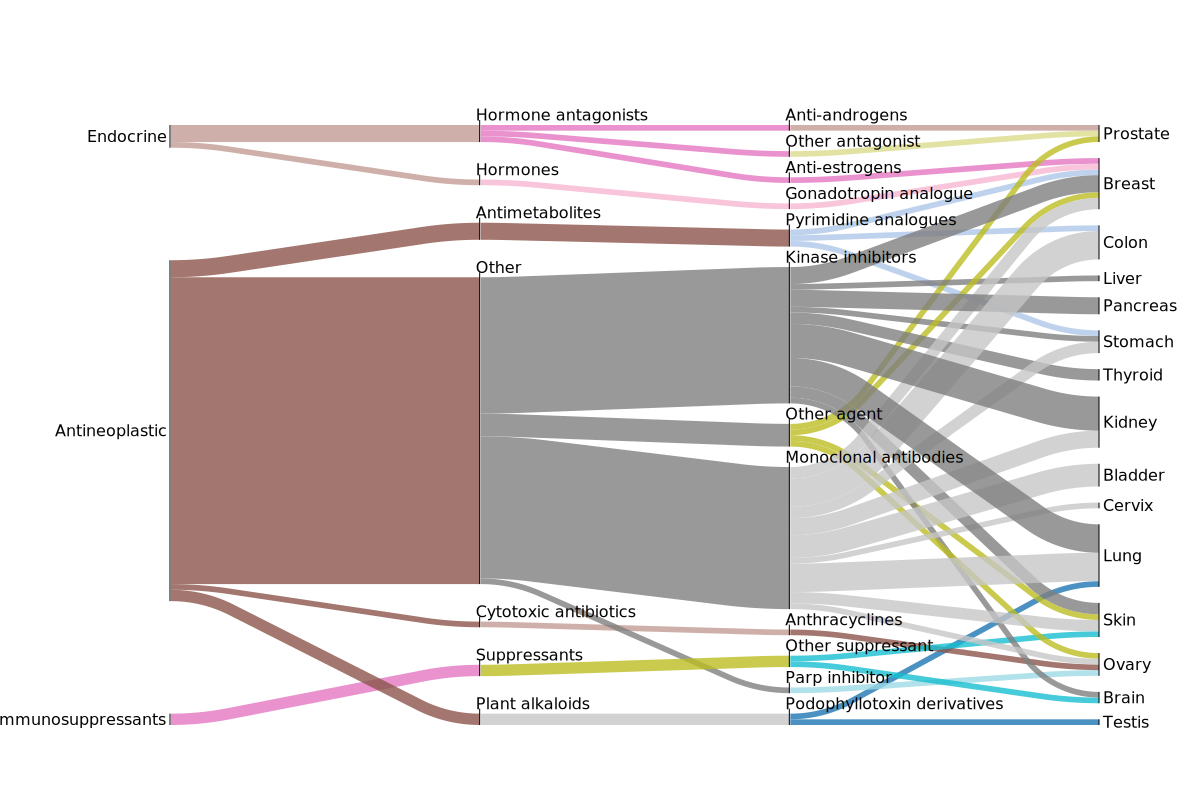

In [160]:
mkdir